## Autorzy

- Hubert Lewandowski
- Filip Wielgosz

# Predykcyjne modelowanie wynagrodze≈Ñ dla biznesu

**Cel naukowy i biznesowy**: Zbudowaƒá replikowalny pipeline ETL ‚Üí EDA ‚Üí in≈ºynieria cech ‚Üí modelowanie (XGBoost) z tunowaniem (Optuna) do **prognozowania `salary_in_usd`**, aby wesprzeƒá dzia≈Çy HR w **szybszym i bardziej obiektywnym** kszta≈Çtowaniu wide≈Çek p≈Çacowych.

**G≈Ç√≥wne za≈Ço≈ºenia**: integrujemy wiele ≈∫r√≥de≈Ç (Kaggle), ujednolicamy nazewnictwo, dodajemy cechy semantyczne (zeroshot + embeddings), dzielimy dane na regiony i budujemy modele per‚Äësegment; transparentno≈õƒá zapewniajƒÖ wykresy EDA oraz interpretowalno≈õƒá SHAP.

**3 kluczowe korzy≈õci dla Biznesu:**
1) **Sp√≥jno≈õƒá i fair‚Äëpay** ‚Äì jednolity, data‚Äëdriven punkt odniesienia do decyzji o ofertach.
2) **Skr√≥cone time‚Äëto‚Äëoffer** ‚Äì szybsza kalibracja wide≈Çek dla konkretnych r√≥l/region√≥w.
3) **Scenariusze ‚Äûco‚Äëje≈õli‚Äù** ‚Äì mo≈ºliwo≈õƒá symulacji wp≈Çywu stanowiska, modelu pracy czy wielko≈õci firmy na p≈Çacƒô.


<br><br><br>
## Konfiguracja ≈õcie≈ºek
Ustawiamy katalog bazowy i lokalizacjƒô mapowa≈Ñ (`mappings/`) wykorzystywanych w ETL i feature engineering.

In [1]:
import os

BASE_DIR = os.getcwd()
MAPS_DIR = os.path.join(BASE_DIR, "..", "mappings")

<br><br><br>
## Importy modu≈Ç√≥w projektu
- `ETLPipeline` ‚Äì ekstrakcja 3 zbior√≥w z Kaggle, standaryzacja kolumn, warto≈õci i nazw pa≈Ñstw.
- `EDA` ‚Äì opis danych, korelacje (num + kategorie via wsp√≥≈Çczynnik eta), outliers i geografia.
- `FeatureEngineer` ‚Äì czyszczenie i cechy semantyczne (zeroshot + embeddings) na tytu≈Çach r√≥l.
- `RegionEDA` ‚Äì por√≥wnania US+CA+UK vs Rest (mediany, rozk≈Çady, trendy, size/work model).
- `XGBoost` ‚Äì prosty wrapper na trenowanie i strojenie z OptunƒÖ.

In [2]:
from eda import EDA
from region_eda import RegionEDA
from etl import ETLPipeline
from feature_eng import FeatureEngineer
from xgb import XGBoost

<br><br><br>
## ETL ‚Äì ekstrakcja i standaryzacja
Pobieramy 3 publiczne zbiory **Kaggle** i ≈ÇƒÖczymy je w jednƒÖ tabelƒô. `transform()` korzysta z mapowa≈Ñ kolumn (`columns.json`) i warto≈õci (`values.json`), normalizuje nazwy kraj√≥w (ISO ‚Üí `name_short`) i usuwa indeksy‚Äëwydmuszki; nastƒôpnie deduplikacja i sort po `work_year`.

In [3]:
etl = ETLPipeline()

etl.extract("ruchi798/data-science-job-salaries", "ds_salaries.csv")
etl.extract("sazidthe1/data-science-salaries", "data_science_salaries.csv")
etl.extract("arnabchaki/data-science-salaries-2025", "salaries.csv")

etl.transform(
    columns_map=os.path.join(MAPS_DIR, "columns.json"),
    values_map=os.path.join(MAPS_DIR, "values.json"),
)

dataset = etl.load()

Std. custom: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<00:00, 44.03it/s]


<br><br><br>
## EDA ‚Äì opis podstawowy, korelacje, outliers i geografia
Uruchamiamy metody: 
- `describe()` ‚Üí statystyki i unikalno≈õci; 
- `correlations()` ‚Üí skorelowanie cech z celem (`salary_in_usd`), w tym **eta** dla kategorii; 
- `outliers()` ‚Üí box‚Äëplota/Top‚ÄëN kategorie; 
- `geography_salary()` ‚Üí top lokalizacje wg **skorygowanego** 95. percentyla.

Missing values or NaNs: 0
Data dimensions (w x h): 52,938 x 11

                    unique_values
salary_in_usd               10537
salary                       9484
job_title                     363
employee_residence             98
company_location               92
salary_currency                27
work_year                       6
experience_level                4
employment_type                 4
work_model                      3
company_size                    3

                    mean        std     min      25%       50%       75%  \
work_year        2024.20       0.76  2020.0   2024.0    2024.0    2025.0   
salary         161954.80  300361.98  4000.0  96600.0  140000.0  193000.0   
salary_in_usd  151657.66   77900.82  2859.0  96500.0  139587.0  191000.0   

                      max  
work_year          2025.0  
salary         30400000.0  
salary_in_usd    800000.0  

                   unique             top   freq
experience_level        4          Senior  27989
employment_

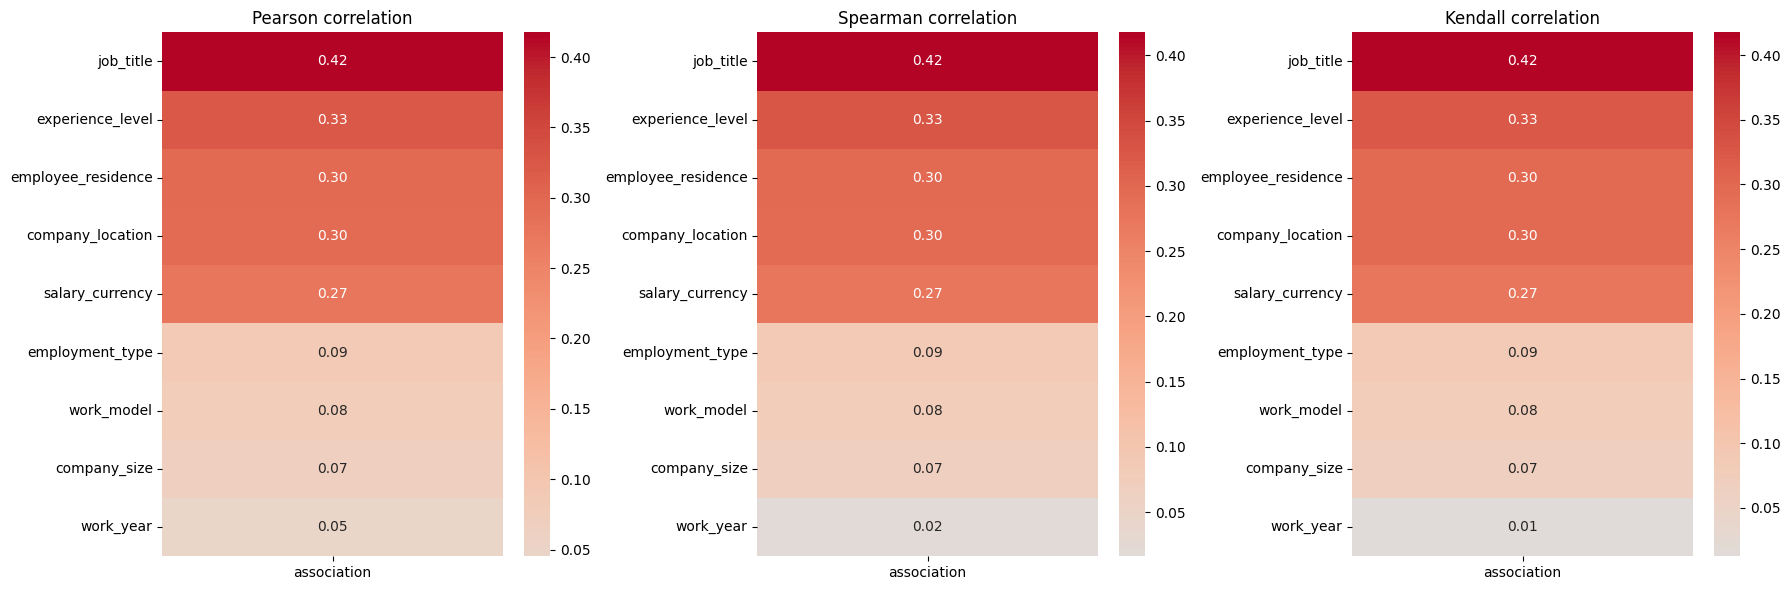

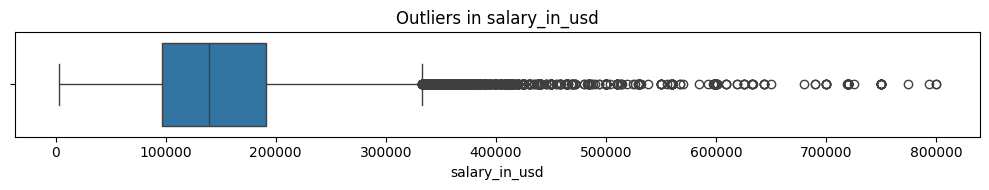

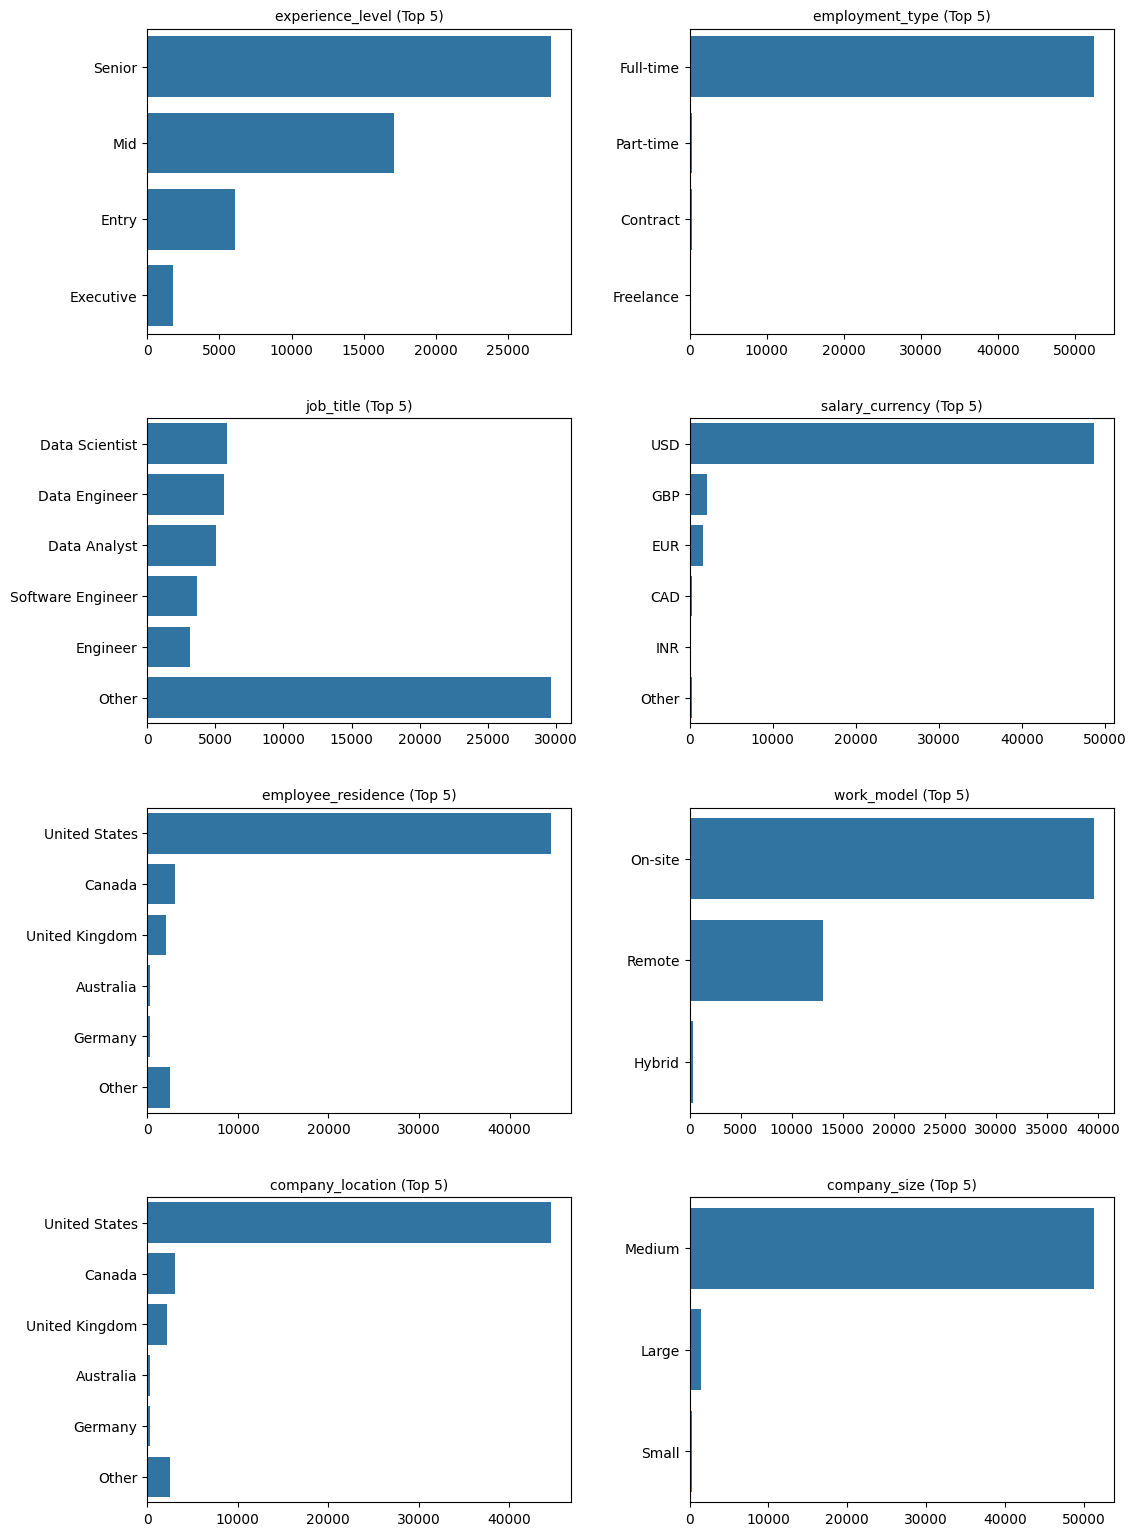

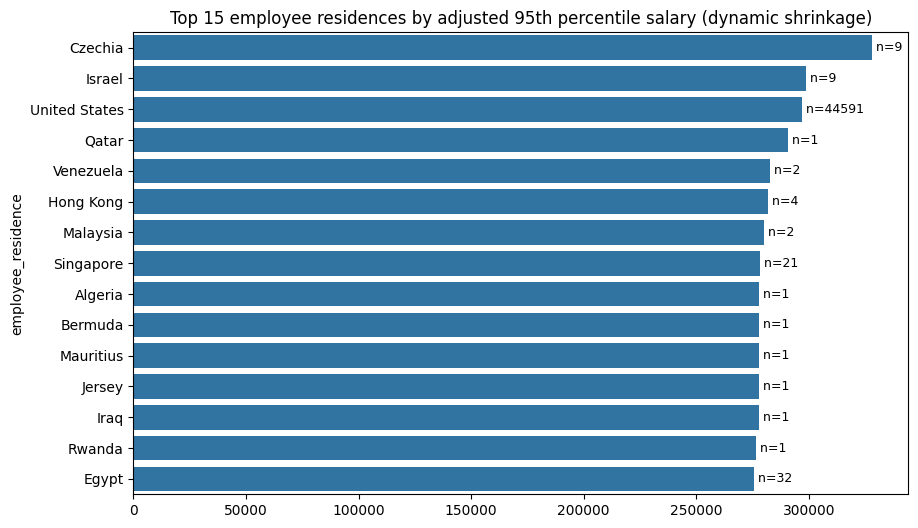

In [4]:
eda = EDA(dataset)
eda.describe()
eda.correlations(target="salary_in_usd", exclude_cols=["salary"])
eda.outliers(exclude_cols=["work_year", "salary"], top_n=5)
eda.geography_salary()

### EDA ‚Äì kluczowe wyniki i interpretacje

#### Top lokalizacje wg 95. percentyla wynagrodze≈Ñ
- **Czechia, Israel, USA** ‚Äì najwy≈ºsze p≈Çace, przy czym wynik USA jest najbardziej wiarygodny (du≈ºa pr√≥ba ~44k), a Czechia i Israel bazujƒÖ na ma≈Çych pr√≥bkach (~9).  
- **Qatar, Venezuela, Hong Kong, Malaysia, Singapore** ‚Äì wysokie wynagrodzenia, ale na ma≈Çych pr√≥bach ‚Üí wyniki orientacyjne.  
- **Egypt (n=32)** ‚Äì wyjƒÖtek w≈õr√≥d mniejszych kraj√≥w, relatywnie wysoka wiarygodno≈õƒá.  
- **Algeria, Bermuda, Mauritius, Jersey, Iraq, Rwanda** ‚Äì pojedyncze obserwacje, nie mo≈ºna wyciƒÖgaƒá wniosk√≥w.  

-> **Wniosek:** USA pozostaje najbardziej wiarygodnym rynkiem wysokich p≈Çac, reszta kraj√≥w przy ma≈Çych pr√≥bach powinna byƒá traktowana ostro≈ºnie.  

---

#### Najczƒôstsze warto≈õci zmiennych kategorycznych
- **Poziom do≈õwiadczenia** ‚Äì dominuje **Senior**, potem **Mid** i **Entry**.  
- **Typ zatrudnienia** ‚Äì zdecydowana wiƒôkszo≈õƒá to **Full-time**.  
- **Stanowisko** ‚Äì najczƒô≈õciej **Data Scientist, Data Engineer, Data Analyst**, ale du≈ºy rozrzut tytu≈Ç√≥w trafia do kategorii *Other*.  
- **Waluta** ‚Äì wyra≈∫na dominacja **USD**.  
- **Miejsce zamieszkania pracownika** ‚Äì g≈Ç√≥wnie **USA**, w mniejszym stopniu Kanada, UK, Australia, Niemcy.  
- **Model pracy** ‚Äì przewa≈ºa **On-site**, potem **Remote**, marginalnie **Hybrid**.  
- **Lokalizacja firmy** ‚Äì g≈Ç√≥wnie **USA**, dalej Kanada, UK, Australia, Niemcy.  
- **Wielko≈õƒá firmy** ‚Äì dominujƒÖ **Medium**, mniej **Large** i **Small**.  

-> **Wniosek:** Dane sƒÖ mocno skoncentrowane na rynku USA, rolach data/IT i pracy etatowej w firmach ≈õredniej wielko≈õci.  

---

#### Korelacje z `salary_in_usd`
- **`job_title`** (‚âà0.42) ‚Äì najwa≈ºniejszy czynnik r√≥≈ºnicujƒÖcy p≈Çace.  
- **`experience_level`** (‚âà0.33) ‚Äì istotny wp≈Çyw do≈õwiadczenia na zarobki.  
- **`employee_residence`** i **`company_location`** (‚âà0.30) ‚Äì lokalizacja ma du≈ºe znaczenie.  
- **`salary_currency`** (‚âà0.27) ‚Äì odzwierciedla zwiƒÖzek waluty i regionu z poziomem p≈Çac.  
- **`employment_type`**, **`work_model`**, **`company_size`** (<0.1) ‚Äì wp≈Çyw s≈Çaby, kontekstowy.  
- **`work_year`** (‚âà0.0) ‚Äì rok nie ma du≈ºego znaczenia, r√≥≈ºnice sƒÖ subtelne.  

-> **Wniosek:** p≈Çace najlepiej t≈ÇumaczƒÖ stanowisko, do≈õwiadczenie i geografia ‚Äì inne czynniki sƒÖ wt√≥rne.  

---

### Podsumowanie:
- **Najsilniejsze determinanty p≈Çac**: rola, do≈õwiadczenie i lokalizacja.  
- **Dane**: dominujƒÖ USA, etaty full-time i firmy ≈õredniej wielko≈õci ‚Üí model najlepiej sprawdzi siƒô dla takich przypadk√≥w.  
- **Geografia**: USA i Kanada wyra≈∫nie przewy≈ºszajƒÖ Europƒô, a w ‚ÄûRest‚Äù wyr√≥≈ºnia siƒô Australia.  
- **Specjalizacje**: dominujƒÖ ‚Äûdata‚Äù, ale AI i akademia mogƒÖ przynosiƒá dodatkowƒÖ premiƒô.  

-> EDA potwierdza, ≈ºe globalny rynek p≈Çac w obszarze Data/IT jest mocno zr√≥≈ºnicowany i silnie zale≈ºy od **lokalizacji** i **stanowiska**, a pozosta≈Çe czynniki majƒÖ znaczenie drugorzƒôdne.  


<br><br><br>
## In≈ºynieria cech na tytu≈Çach stanowisk
- `cleanup()` ‚Äì usuwa `salary`, czy≈õci `job_title` z poziom√≥w (junior/senior/‚Ä¶)
- `prepare()` ‚Äì normalizuje `work_model` oraz dodaje `research_related` (fuzz),
- `cluster_careers()` ‚Äì **zero‚Äëshot** (BART‚ÄëMNLI) + embeddingi SBERT do miƒôkkiego przypisu r√≥l do temat√≥w z `topics.json` ‚Üí kolumny `p_*`,
- `print_examples()` ‚Äì pr√≥bka r√≥l z ich wektorami `p_*`.
Na ko≈Ñcu aktualizujemy `dataset = eng.dataset`.

In [5]:
eng = FeatureEngineer(dataset)
eng.cleanup()
eng.prepare()
eng.cluster_careers(os.path.join(MAPS_DIR, "topics.json"))
eng.print_examples(n = 10)

dataset = eng.dataset

Device set to use cuda:0
Merging synonyms of titles: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 351/351 [00:00<00:00, 4912.64it/s]

[cache] Loaded from cache/careers_53a5fc98d81b8ae9ff994437590842ac.parquet
Data Engineer                  | p_ai=0.05, p_data=0.95, p_software=0.32, p_academic=0.00
Software Engineer              | p_ai=0.00, p_data=0.37, p_software=0.83, p_academic=0.00
Engineer                       | p_ai=0.68, p_data=0.78, p_software=0.29, p_academic=0.00
Data Architect                 | p_ai=0.00, p_data=0.56, p_software=0.12, p_academic=0.00
Engineer                       | p_ai=0.68, p_data=0.78, p_software=0.29, p_academic=0.00
Developer                      | p_ai=0.00, p_data=0.91, p_software=0.82, p_academic=0.08
AI Engineer                    | p_ai=0.85, p_data=0.71, p_software=0.12, p_academic=0.05
Analytics Specialist           | p_ai=0.01, p_data=0.92, p_software=0.00, p_academic=0.02
Data Analyst                   | p_ai=0.01, p_data=0.95, p_software=0.00, p_academic=0.00
Data Architect                 | p_ai=0.00, p_data=0.56, p_software=0.12, p_academic=0.00


<br><br><br>
## Segmentacja na **US+CA+UK** vs **Rest** i przyciƒôcie ogon√≥w
Filtrujemy kraje z ‚â•200 obserwacjami. Tworzymy etykietƒô regionu i **przycinamy 95. percentyl** `salary_in_usd` per region, aby ograniczyƒá wp≈Çyw ekstremalnych obserwacji.

In [6]:
# ile pr√≥bek ma ka≈ºdy kraj
counts = dataset["employee_residence"].value_counts()

# kraje z min 100 obserwacjami
valid_countries = counts[counts >= 200].index
filtered = dataset[dataset["employee_residence"].isin(valid_countries)].copy()

# przypisz etykiety region√≥w
filtered["region_group"] = filtered["employee_residence"].apply(
    lambda c: "US+CA+UK" if c in {"United States", "Canada", "United Kingdom"} else "Rest"
)

# podzia≈Ç na regiony P95
def trim_region(df, col="salary_in_usd", q=0.95):
    cutoff = df[col].quantile(q)
    return df[df[col] <= cutoff].copy()

us_ca_uk = trim_region(filtered[filtered["region_group"] == "US+CA+UK"])
rest     = trim_region(filtered[filtered["region_group"] == "Rest"])

<br><br><br>
## Analiza por√≥wnawcza region√≥w (RegionEDA)
Generujemy zestaw wykres√≥w: **Median by residence**, **Field profiles (`p_*`)**, **Corr(fields‚Üîsalary)**, **Distributions**, **Trends**, **Company size** (violin) i **Work model** (box).

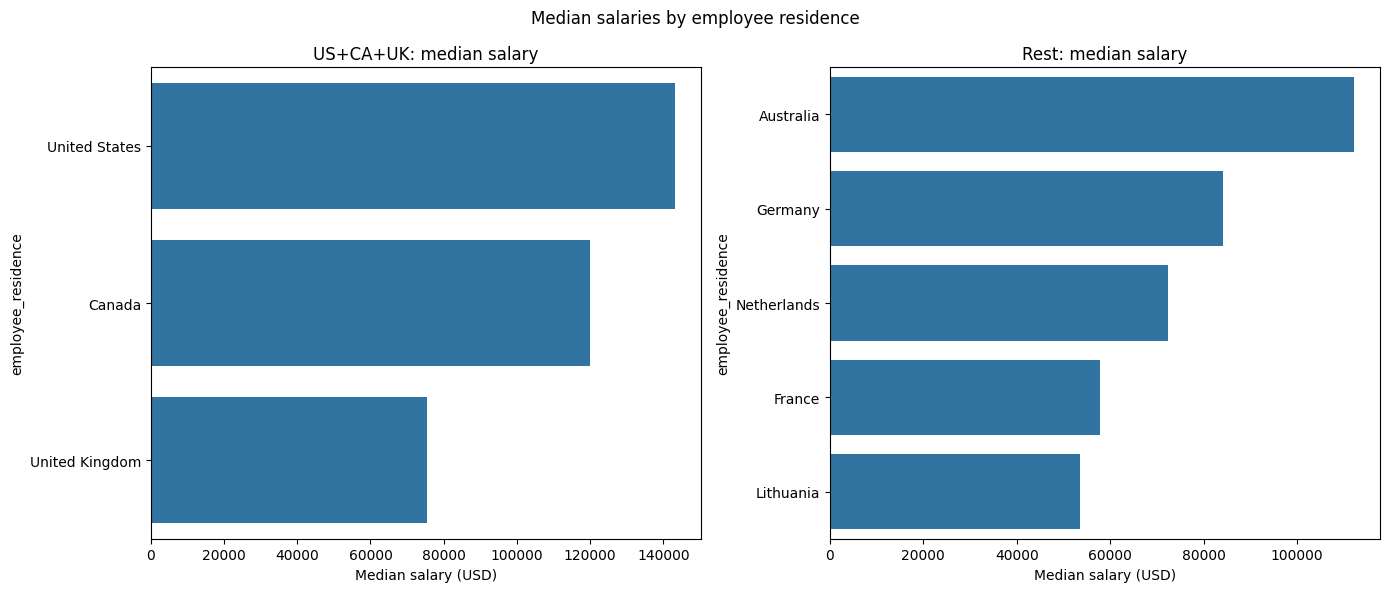

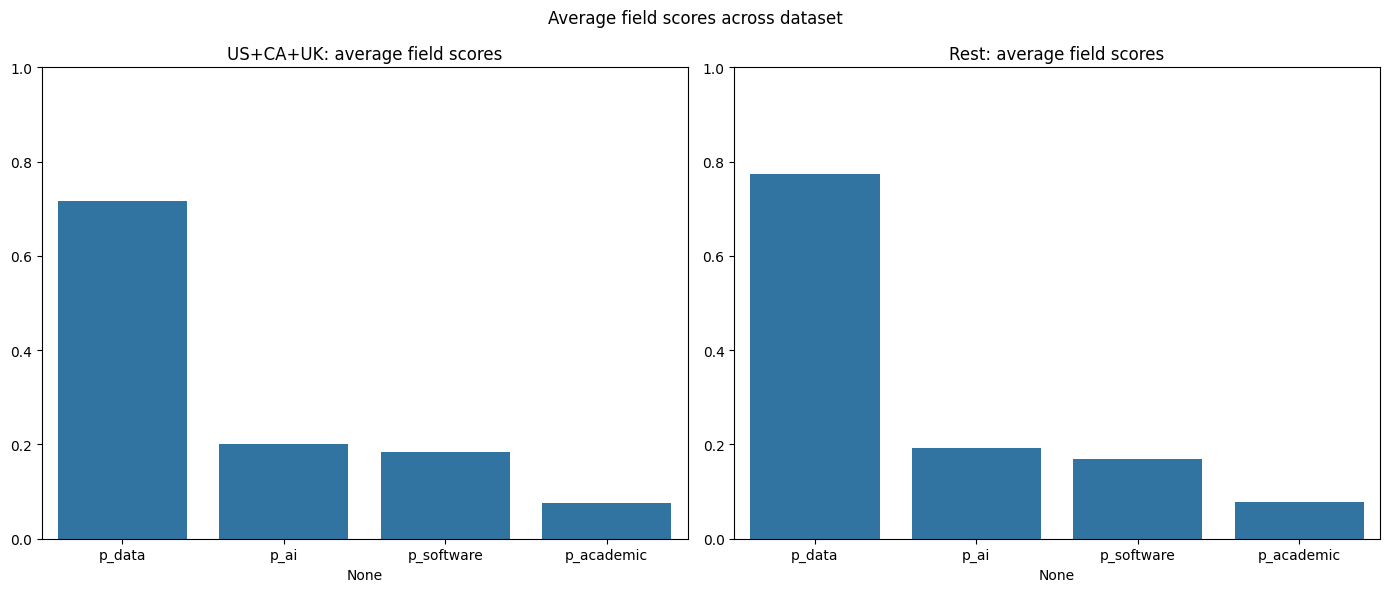

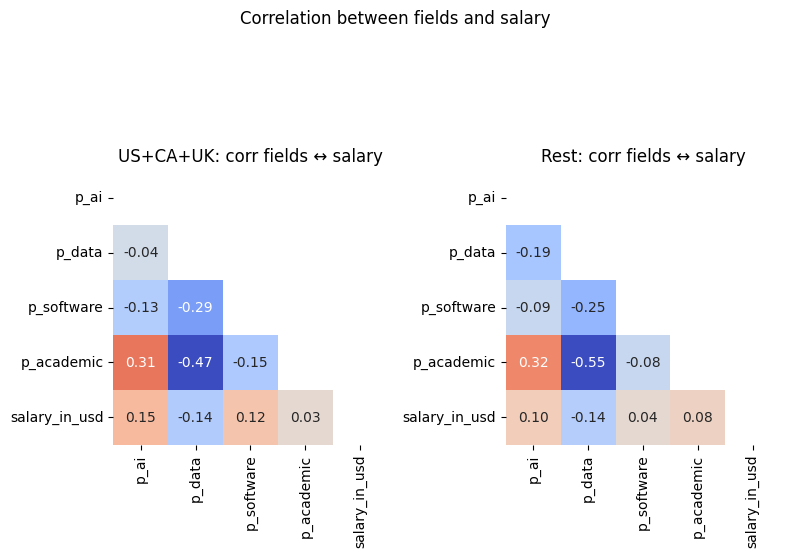

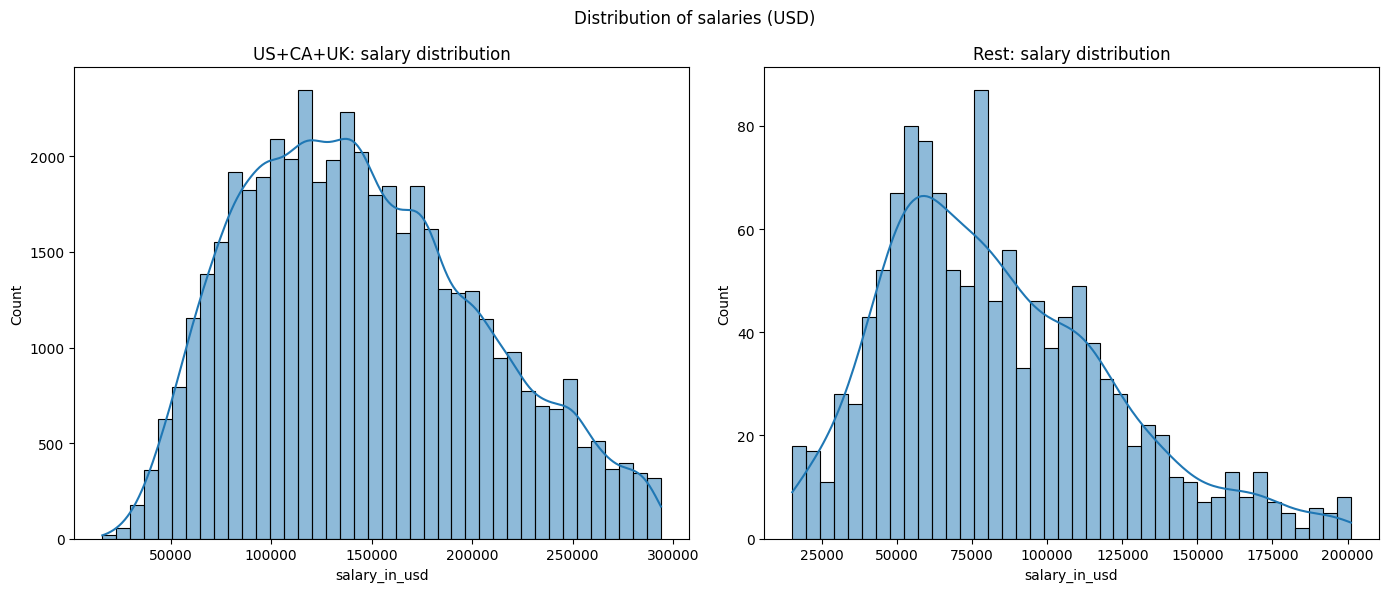

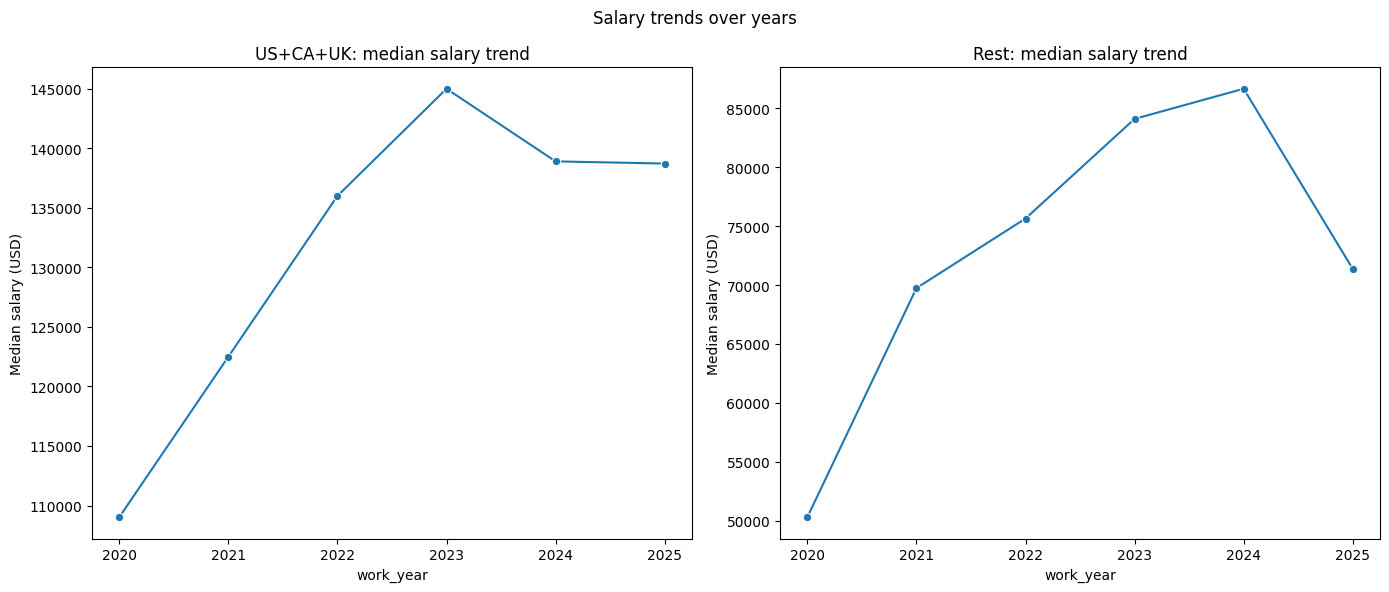

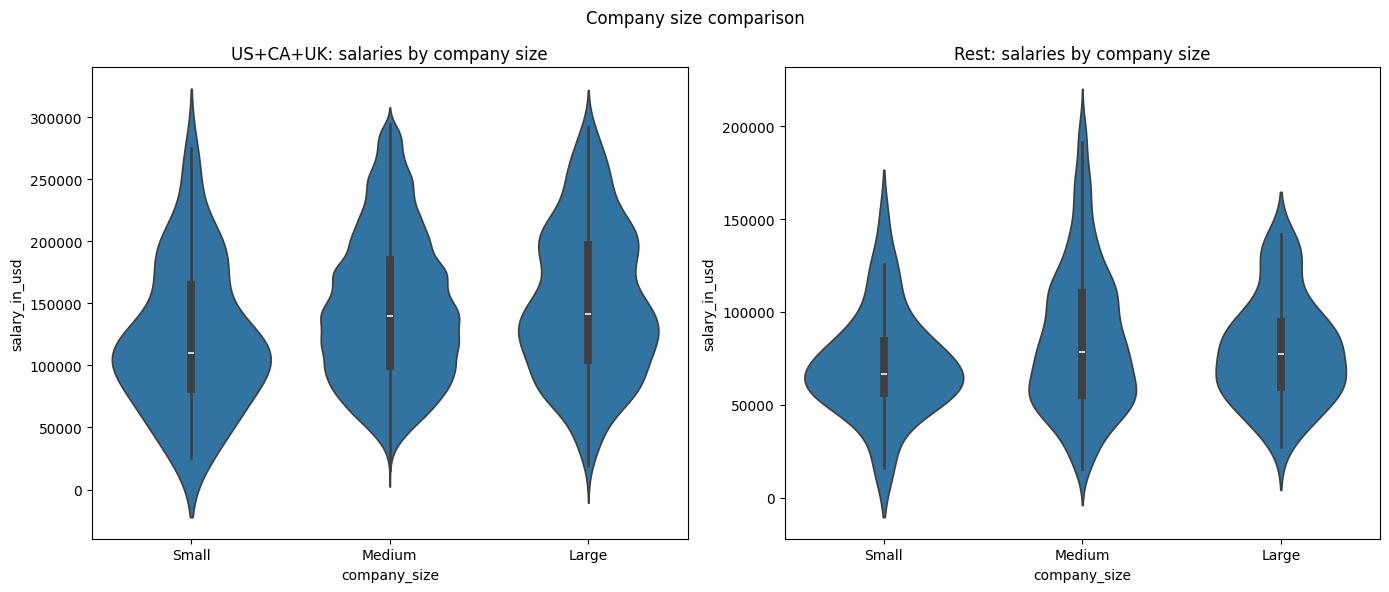

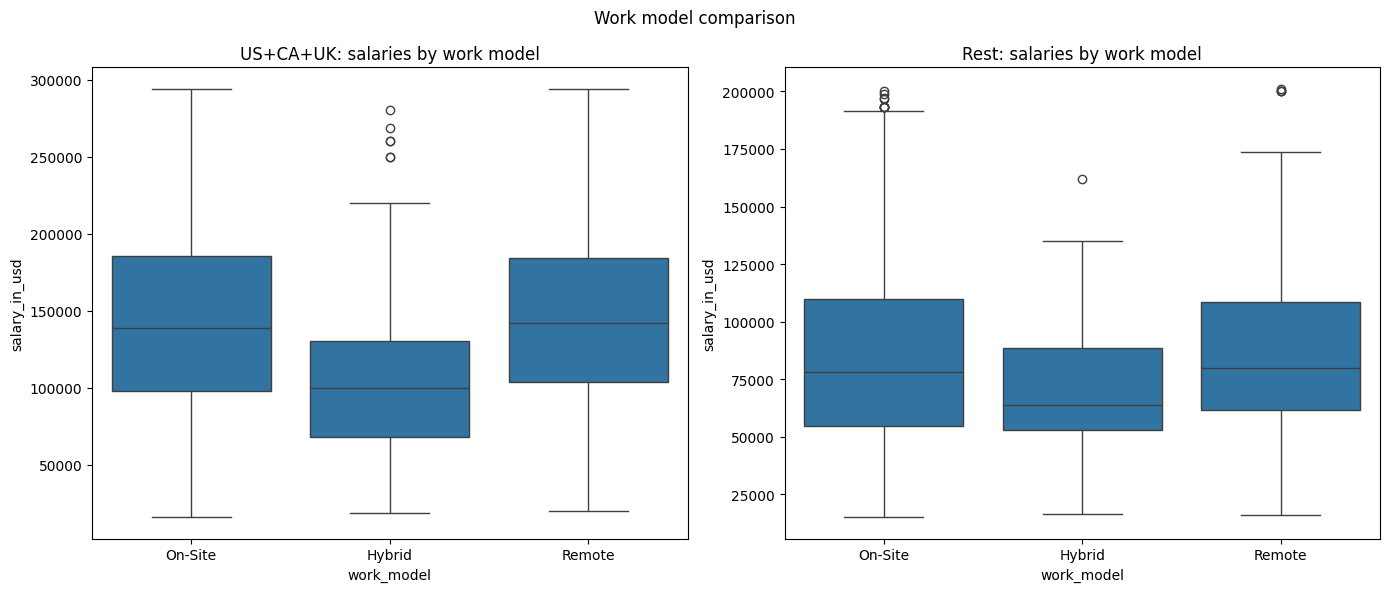

In [7]:
report_eda = RegionEDA(us_ca_uk, rest, os.path.join(MAPS_DIR, "orders.json"))

report_eda.geography_salary()
report_eda.field_profiles()
report_eda.salary_distributions()
report_eda.salary_trends()
report_eda.salary_vs_company_size()
report_eda.salary_vs_work_model()

## EDA ‚Äì kluczowe wyniki por√≥wnawcze (US+CA+UK vs. Rest)

### Median salaries by employee residence
- **USA** (~145k USD) i **Kanada** (~120k USD) dominujƒÖ globalnie; **UK** znacznie ni≈ºej (~75k USD).  
- W grupie ‚ÄûRest‚Äù wyr√≥≈ºnia siƒô **Australia** (~112k USD), dalej **Niemcy** (~85k), **Holandia** (~72k), **Francja** (~58k), **Litwa** (~52k).  

-> **Wniosek:** Lokalizacja jest jednym z kluczowych czynnik√≥w ‚Äì rynek ameryka≈Ñski i anglosaski wyra≈∫nie przewy≈ºsza Europƒô kontynentalnƒÖ.  

---

### Average field scores
- **p_data** (0.7‚Äì0.8) ‚Äì dominujƒÖ kompetencje zwiƒÖzane z analizƒÖ danych.  
- **p_ai** (~0.2) ‚Äì zauwa≈ºalny, ale wciƒÖ≈º mniejszy segment.  
- **p_software** (~0.18) i **p_academic** (<0.1) ‚Äì marginalne.  

-> **Wniosek:** rynek pracy opiera siƒô g≈Ç√≥wnie na rolach zwiƒÖzanych z danymi; AI to rosnƒÖca, ale wciƒÖ≈º mniejsza specjalizacja.  

---

### Correlation between fields and salary
- **US+CA+UK**: lekko dodatnia korelacja p≈Çac z AI i pracƒÖ akademickƒÖ (~0.1‚Äì0.3), brak zwiƒÖzku lub ujemna korelacja dla data/software.  
- **Rest**: podobnie, ale **p_academic** ma najwy≈ºszƒÖ korelacjƒô (~0.32), choƒá przy ma≈Çej pr√≥bie.  

-> **Wniosek:** niszowe obszary (AI, akademia) mogƒÖ wiƒÖzaƒá siƒô z premiƒÖ p≈ÇacowƒÖ, typowe role data/software ‚Äì niekoniecznie.  

---

### Distribution of salaries
- **US+CA+UK**: najwiƒôcej p≈Çac w wide≈Çkach 100k‚Äì150k USD, czƒôste >200k USD.  
- **Rest**: szczyt w wide≈Çkach 50k‚Äì80k USD, rzadkie >150k USD.  

-> **Wniosek:** rynek anglosaski oferuje wyra≈∫nie wy≈ºsze p≈Çace i wiƒôksze zr√≥≈ºnicowanie wynagrodze≈Ñ.  

---

### Salary trends over years
- **US+CA+UK**: wzrost z ~109k (2020) do ~145k (2023), nastƒôpnie stabilizacja/spadek.  
- **Rest**: wzrost do 2024 (~87k), potem spadek w 2025 (~72k).  

-> **Wniosek:** globalny trend wzrostu p≈Çac wyhamowa≈Ç po 2023, szczeg√≥lnie poza krajami anglosaskimi.  

---

### Company size comparison
- **US+CA+UK**: najwy≈ºsze mediany i najszerszy rozrzut w firmach **Large**.  
- **Rest**: podobny trend, ale na ni≈ºszych poziomach.  

-> **Wniosek:** wiƒôksze firmy czƒô≈õciej oferujƒÖ wy≈ºsze wynagrodzenia i szersze wide≈Çki.  

---

### Work model comparison
- **US+CA+UK**: **On-site** i **Remote** podobne (~140k), **Hybrid** ni≈ºej.  
- **Rest**: mediany ~75‚Äì80k, niewielkie r√≥≈ºnice miƒôdzy modelami.  

-> **Wniosek:** tryb pracy (stacjonarna/zdalna/hybrydowa) nie jest g≈Ç√≥wnym czynnikiem r√≥≈ºnicujƒÖcym p≈Çace ‚Äì wa≈ºniejsza jest lokalizacja i rozmiar firmy.  

---

## Podsumowanie:
- **Najwa≈ºniejsze czynniki p≈Çac**: lokalizacja, wielko≈õƒá firmy, obszar specjalizacji (AI i akademia mogƒÖ dawaƒá przewagƒô).  
- **US+CA+UK**: najwy≈ºsze p≈Çace, szersze wide≈Çki, trend wzrostowy do 2023.  
- **Rest**: ni≈ºsze mediany, du≈ºe zr√≥≈ºnicowanie regionalne, spadek po 2024.  
- **Model pracy**: ma drugorzƒôdne znaczenie wobec regionu i firmy.  

-> EDA jasno pokazuje, ≈ºe globalne r√≥≈ºnice w wynagrodzeniach wynikajƒÖ przede wszystkim z **lokalizacji** i **specjalizacji**, a nie z samego trybu pracy.


<br><br><br>
## Model XGBoost ‚Äì segment **US+CA+UK**
Strojenie (`tune(n_trials=50)`) i trenowanie (`fit()`) na podziale **train/val 80/20** z `early_stopping`. Model akceptuje kategorie (`enable_categorical=True`, `tree_method='hist'`).

In [8]:
xgb_us_ca_uk = XGBoost(us_ca_uk)

xgb_us_ca_uk.tune(50)
xgb_us_ca_uk.fit()

[I 2025-09-27 09:49:14,148] A new study created in memory with name: no-name-c29d7382-4557-4a6f-99fc-a874a42efa18


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-27 09:49:26,548] Trial 0 finished with value: 58426.66131142528 and parameters: {'n_estimators': 2342, 'learning_rate': 1.3401958989018354e-05, 'max_depth': 11}. Best is trial 0 with value: 58426.66131142528.
[I 2025-09-27 09:49:31,236] Trial 1 finished with value: 52439.68207378836 and parameters: {'n_estimators': 1908, 'learning_rate': 0.0003313521907474857, 'max_depth': 7}. Best is trial 1 with value: 52439.68207378836.
[I 2025-09-27 09:49:37,570] Trial 2 finished with value: 57931.20775540589 and parameters: {'n_estimators': 838, 'learning_rate': 7.369378970186385e-05, 'max_depth': 14}. Best is trial 1 with value: 52439.68207378836.
[I 2025-09-27 09:49:42,636] Trial 3 finished with value: 57772.616904550894 and parameters: {'n_estimators': 2219, 'learning_rate': 3.324891925000429e-05, 'max_depth': 7}. Best is trial 1 with value: 52439.68207378836.
[I 2025-09-27 09:49:45,579] Trial 4 finished with value: 57940.113634683185 and parameters: {'n_estimators': 2356, 'learning_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08470716986507085, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2790, n_jobs=None,
             num_parallel_tree=None, ...)

Interpretacja:

- RMSE ~49k oznacza, ≈ºe ≈õredni b≈ÇƒÖd kwadratowy odpowiada mniej wiƒôcej ¬±50 tys. w jednostkach Twojej zmiennej zale≈ºnej (tu chyba wynagrodzenie).
- MAE ~40k to przeciƒôtny b≈ÇƒÖd bezwzglƒôdny ‚Äì model myli siƒô ≈õrednio o oko≈Ço 40k.
- R¬≤ ~0.30 oznacza, ≈ºe model t≈Çumaczy oko≈Ço 30% wariancji w danych. To nie jest bardzo dobry wynik ‚Äì znaczy, ≈ºe sporo zale≈ºy od czynnik√≥w, kt√≥rych model nie widzi, albo ≈ºe dane sƒÖ bardzo rozproszone.

### Co to m√≥wi praktycznie?

- Model nauczy≈Ç siƒô czego≈õ (R¬≤ > 0), wiƒôc uchwyci≈Ç istotne zale≈ºno≈õci (np. stanowisko, waluta, do≈õwiadczenie ‚Äì co widaƒá w SHAP).
- Jednocze≈õnie jest spory margines b≈Çƒôdu ‚Äì wiƒôc na poziomie indywidualnym przewidywania mogƒÖ byƒá mocno nietrafione.
- Model jest raczej u≈ºyteczny do analiz trend√≥w i por√≥wna≈Ñ, a nie do dok≈Çadnego przewidywania pojedynczych warto≈õci.

In [9]:
xgb_rest = XGBoost(rest)

xgb_rest.tune(50)
xgb_rest.fit()

[I 2025-09-27 09:50:41,224] A new study created in memory with name: no-name-54f64be7-3e4b-4723-899e-784990da90eb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-27 09:50:43,467] Trial 0 finished with value: 40026.28416428385 and parameters: {'n_estimators': 1691, 'learning_rate': 3.8114477843573556e-05, 'max_depth': 13}. Best is trial 0 with value: 40026.28416428385.
[I 2025-09-27 09:50:43,742] Trial 1 finished with value: 30348.956094073485 and parameters: {'n_estimators': 2552, 'learning_rate': 0.005674973181465597, 'max_depth': 2}. Best is trial 1 with value: 30348.956094073485.
[I 2025-09-27 09:50:43,776] Trial 2 finished with value: 30488.553130642325 and parameters: {'n_estimators': 2297, 'learning_rate': 0.2249899279724591, 'max_depth': 5}. Best is trial 1 with value: 30348.956094073485.
[I 2025-09-27 09:50:43,876] Trial 3 finished with value: 31376.655781010188 and parameters: {'n_estimators': 844, 'learning_rate': 0.03976190936024066, 'max_depth': 9}. Best is trial 1 with value: 30348.956094073485.
[I 2025-09-27 09:50:44,390] Trial 4 finished with value: 30360.71356210193 and parameters: {'n_estimators': 1429, 'learning_rat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2636856808480222, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1933, n_jobs=None,
             num_parallel_tree=None, ...)

Interpretacja:

- RMSE ~30k oznacza, ≈ºe ≈õredni b≈ÇƒÖd kwadratowy odpowiada mniej wiƒôcej ¬±30 tys. w jednostkach zmiennej zale≈ºnej (prawdopodobnie wynagrodzenie).
- MAE ~21,8k to przeciƒôtny b≈ÇƒÖd bezwzglƒôdny ‚Äì model myli siƒô ≈õrednio o oko≈Ço 22 tys.
- R¬≤ ~0.46 oznacza, ≈ºe model t≈Çumaczy ok. 46% wariancji w danych. To wyra≈∫nie lepiej ni≈º wcze≈õniejszy wynik (~0.30), ale nadal oznacza, ≈ºe ponad po≈Çowa zmienno≈õci zale≈ºy od czynnik√≥w niewidocznych w danych albo od du≈ºego szumu.

### Co to m√≥wi praktycznie?

- Model wyra≈∫nie lepiej uczy siƒô zale≈ºno≈õci ‚Äì uchwyci≈Ç wiƒôcej struktury i przewiduje z mniejszym b≈Çƒôdem ni≈º poprzedni (mniejsze RMSE i MAE, wy≈ºsze R¬≤).
- Nadal jednak b≈Çƒôdy jednostkowe sƒÖ spore ‚Äì przy wynagrodzeniach myli siƒô ≈õrednio o ~22 tys., wiƒôc prognoza dla pojedynczej osoby mo≈ºe mocno odbiegaƒá od rzeczywisto≈õci.
- Model jest bardziej u≈ºyteczny do analiz por√≥wnawczych i trend√≥w (np. kt√≥re cechy najmocniej podbijajƒÖ p≈Çacƒô) ni≈º do precyzyjnych prognoz indywidualnych wynagrodze≈Ñ.

<br><br><br>
## SHAP ‚Äì interpretacja modeli
Obliczamy warto≈õci SHAP dla modelu segmentu *Rest* (po zakodowaniu kategorii do kod√≥w). Tworzymy trzy wykresy: **summary**, **bar** (global importance) i **waterfall** (wyja≈õnienie lokalne).

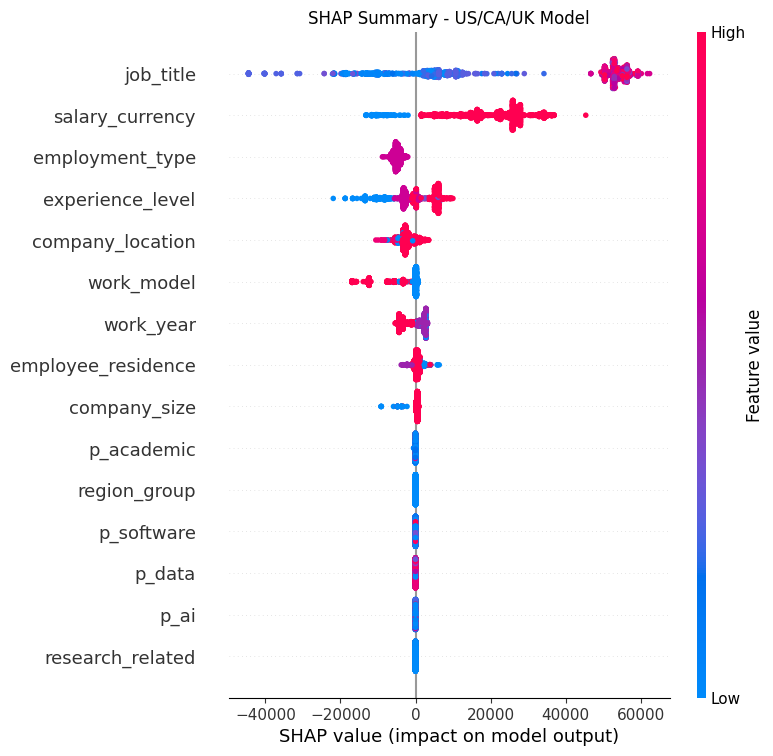

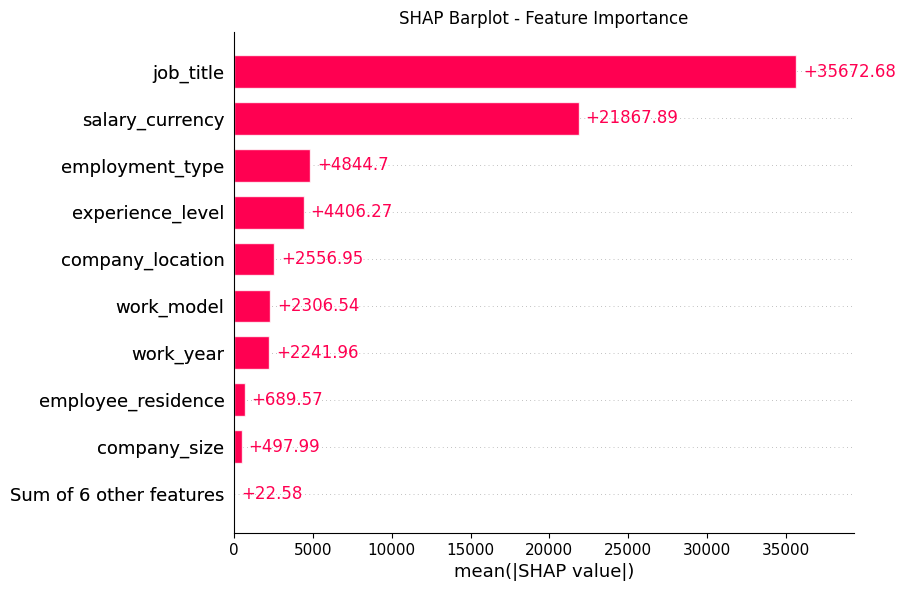

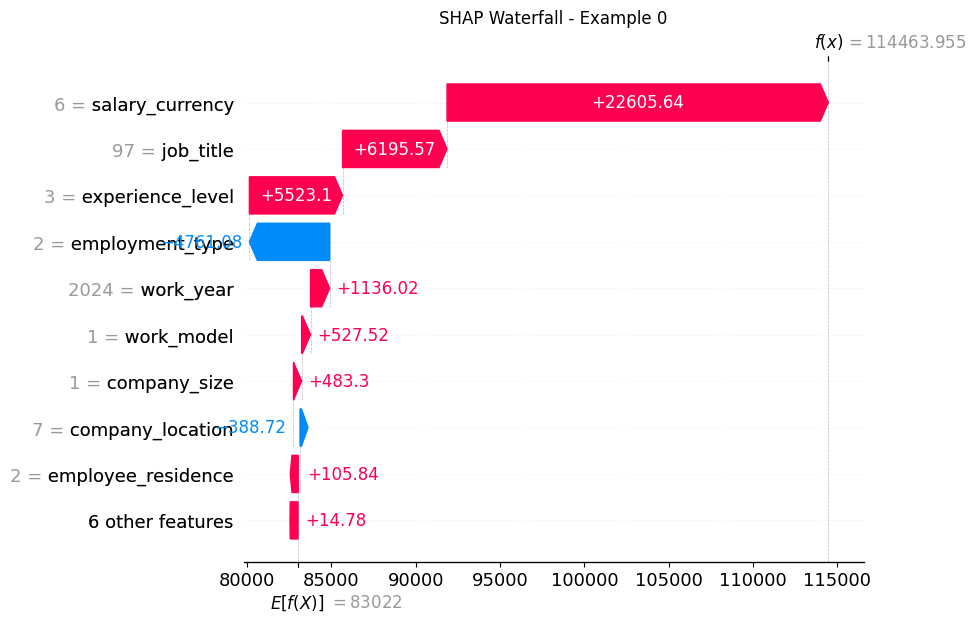

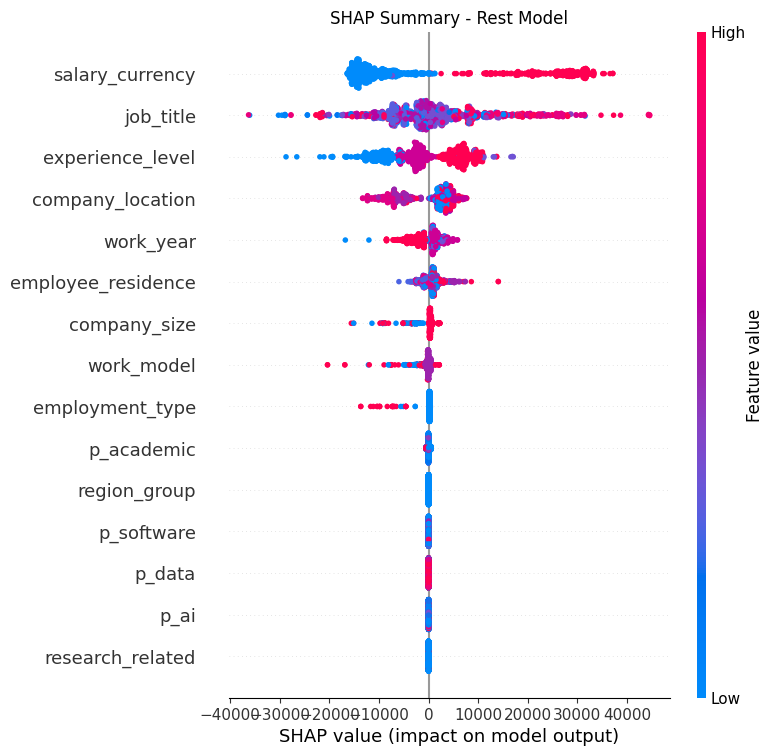

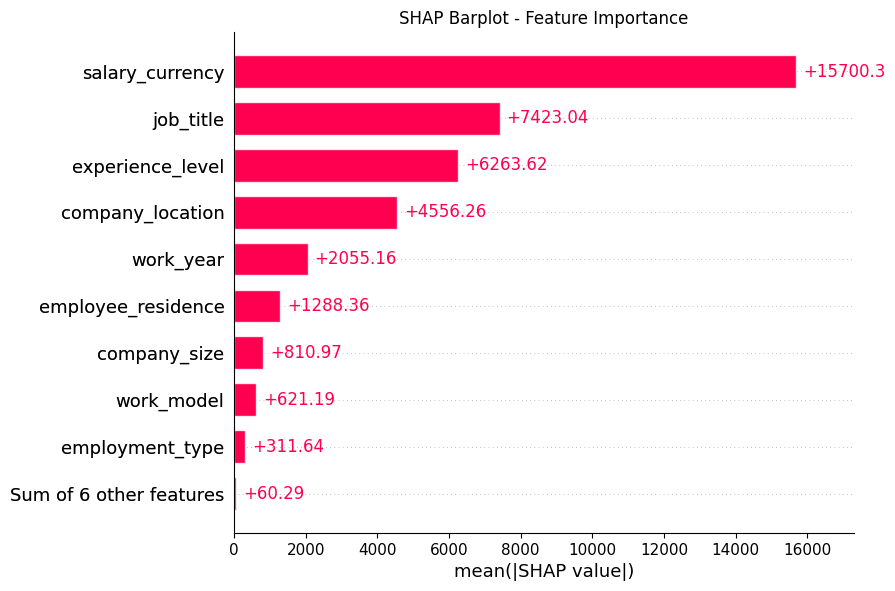

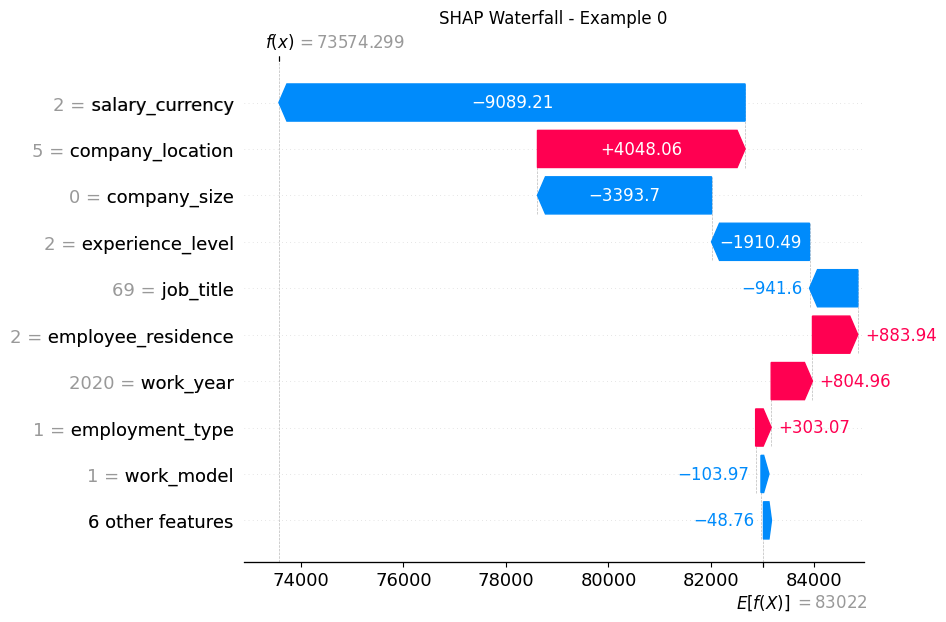

In [11]:
import matplotlib.pyplot as plt
import shap

# zr√≥b wersjƒô danych numerycznych tylko do SHAP
X_numeric = xgb_us_ca_uk.X.copy()
for col in X_numeric.select_dtypes(include="category"):
    X_numeric[col] = X_numeric[col].cat.codes

n_samples = min(2000, len(X_numeric))
X_numeric = X_numeric.sample(n=n_samples, random_state=42)

# TreeExplainer dla XGBoost
explainer = shap.TreeExplainer(xgb_rest.model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_numeric)

# summary plot z tytu≈Çem
shap.summary_plot(shap_values, X_numeric, show=False)
plt.title("SHAP Summary - US/CA/UK Model")
plt.show()

# bar plot z tytu≈Çem
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Barplot - Feature Importance")
plt.show()

# waterfall dla jednej obserwacji
shap.plots.waterfall(shap_values[0], show=False)
plt.title("SHAP Waterfall - Example 0")
plt.show()





# zr√≥b wersjƒô danych numerycznych tylko do SHAP
X_numeric = xgb_rest.X.copy()
for col in X_numeric.select_dtypes(include="category"):
    X_numeric[col] = X_numeric[col].cat.codes

# TreeExplainer dla XGBoost
explainer = shap.TreeExplainer(xgb_rest.model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_numeric)

# summary plot z tytu≈Çem
shap.summary_plot(shap_values, X_numeric, show=False)
plt.title("SHAP Summary - Rest Model")
plt.show()

# bar plot z tytu≈Çem
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Barplot - Feature Importance")
plt.show()

# waterfall dla jednej obserwacji
shap.plots.waterfall(shap_values[0], show=False)
plt.title("SHAP Waterfall - Example 0")
plt.show()


# US/CA/UK Model

## Summary plot (globalny rozk≈Çad)

- Stanowisko (job_title) i waluta (salary_currency) najmocniej kszta≈ÇtujƒÖ prognozy.
- Wa≈ºne tak≈ºe: typ zatrudnienia i poziom do≈õwiadczenia.
- Lokalizacja firmy, rok pracy i tryb pracy majƒÖ zauwa≈ºalny, ale mniejszy wp≈Çyw.
- Pozosta≈Çe cechy odgrywajƒÖ rolƒô marginalnƒÖ.

## Bar plot (ranking cech)

- Stanowisko i waluta dominujƒÖ ‚Äì ich wp≈Çyw jest o rzƒÖd wielko≈õci wiƒôkszy ni≈º innych zmiennych.
- Kolejne czynniki to: typ zatrudnienia, do≈õwiadczenie, lokalizacja firmy.
- Reszta cech (np. rozmiar firmy, miejsce zamieszkania) to tylko drobne korekty.
- Waterfall plot (jedna obserwacja)

## Model przewidzia≈Ç 114k vs ≈õrednia 83k.

- Wynik mocno podbi≈Çy: waluta (+22k), stanowisko (+6k) i do≈õwiadczenie (+5,5k).
- Typ zatrudnienia (-4,7k) odjƒÖ≈Ç czƒô≈õƒá warto≈õci.
- Kilka mniejszych czynnik√≥w (rok, tryb pracy, firma) doda≈Ço po kilkaset.

**Bardzo wysoka prognoza, napƒôdzana g≈Ç√≥wnie trzema kluczowymi cechami.**

# Rest

## Summary plot (globalny rozk≈Çad)

- Najwa≈ºniejszym czynnikiem jest waluta wyp≈Çaty ‚Äì mocno r√≥≈ºnicuje prognozowane zarobki.
- Du≈ºe znaczenie ma te≈º stanowisko oraz poziom do≈õwiadczenia.
- Lokalizacja firmy i rok pracy wp≈ÇywajƒÖ na wynik, ale s≈Çabiej.
- Reszta cech (np. wielko≈õƒá firmy, tryb pracy, miejsce zamieszkania) ma niewielki wp≈Çyw.

## Bar plot (ranking cech)

- Waluta i stanowisko dominujƒÖ i wyja≈õniajƒÖ wiƒôkszo≈õƒá r√≥≈ºnic w prognozach.
- Do≈õwiadczenie i lokalizacja sƒÖ drugƒÖ grupƒÖ wa≈ºnych czynnik√≥w.
- Pozosta≈Çe zmienne to jedynie korekty.

## Waterfall plot (jedna obserwacja)

- Model przewidzia≈Ç 73k zamiast ≈õrednich 83k.
- Najbardziej obni≈ºy≈Ça prognozƒô waluta oraz rozmiar firmy.
- Czƒô≈õciowo skorygowa≈Çy to na plus lokalizacja firmy i do≈õwiadczenie, ale nie wystarczy≈Ço, ≈ºeby wyr√≥wnaƒá stratƒô.

**Wynik ko≈Ñcowy jest wiƒôc ni≈ºszy ni≈º ≈õrednia.**



---

# Kierunki rozwoju

1. **Lepsze dopasowanie modelu**  
   Zamiast pojedynczych test√≥w mo≈ºna przeprowadziƒá setki pr√≥b, aby znale≈∫ƒá najlepsze ustawienia i sprawdziƒá, czy model dobrze dzia≈Ça w kolejnych latach, a nie tylko w ca≈Çej pr√≥bie naraz.  

2. **Lepsze przygotowanie danych o p≈Çacach**  
   Mo≈ºna zmieniƒá spos√≥b liczenia warto≈õci wynagrodze≈Ñ (np. u≈ºyƒá skali logarytmicznej) oraz dostosowaƒá je do region√≥w, ≈ºeby por√≥wnania by≈Çy bardziej uczciwe i realistyczne.  

3. **Dodanie dodatkowych czynnik√≥w**  
   Warto wzbogaciƒá dane o takie informacje jak: koszty ≈ºycia w r√≥≈ºnych krajach, wska≈∫niki gospodarcze czy dok≈Çadniejszy opis stanowisk i poziomu do≈õwiadczenia. Trzeba te≈º uwa≈ºaƒá, by model nie dyskryminowa≈Ç pewnych grup.  

4. **Sprawdzenie aktualno≈õci prognoz**  
   Testowanie modelu tylko na danych z ostatniego roku pozwoli oceniƒá, czy potrafi przewidywaƒá obecne p≈Çace. Dodatkowo warto ≈õledziƒá, czy w czasie nie zmienia siƒô struktura rynku, co mog≈Çoby obni≈ºyƒá trafno≈õƒá prognoz.  
